## Do Not change the following cell, just run it

In [1]:
## From stackoverflow: https://stackoverflow.com/questions/12544056/how-do-i-get-the-current-ipython-jupyter-notebook-name/52187331#

from notebook import notebookapp
import urllib
import json
import os
import ipykernel

def notebook_path():
    """Returns the absolute path of the Notebook or None if it cannot be determined
    NOTE: works only when the security is token-based or there is also no password
    """
    connection_file = os.path.basename(ipykernel.get_connection_file())
    kernel_id = connection_file.split('-', 1)[1].split('.')[0]

    for srv in notebookapp.list_running_servers():
        try:
            if srv['token']=='' and not srv['password']:  # No token and no password, ahem...
                req = urllib.request.urlopen(srv['url']+'api/sessions')
            else:
                req = urllib.request.urlopen(srv['url']+'api/sessions?token='+srv['token'])
            sessions = json.load(req)
            for sess in sessions:
                if sess['kernel']['id'] == kernel_id:
                    return os.path.join(srv['notebook_dir'],sess['notebook']['path'])
        except:
            pass  # There may be stale entries in the runtime directory 
    return None

import sys, os, os.path as osp
sys.path += [osp.dirname(osp.dirname(osp.realpath(notebook_path()))), osp.dirname(osp.realpath(notebook_path()))]

In [2]:
import pandas as pd
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.options.display.max_columns = 2000
pd.options.display.max_rows = 400


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/3758627911.py:2: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
from pathlib import Path
sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent.parent)]


In [4]:
import numpy as np
import pandas as pd

## From now on, use the notebook :-)

In [5]:
# !%matplotlib qt
import os
from pathlib import Path
import sys
import glob
import numpy as np
import mne
import pyxdf
import re
from datetime import datetime, timezone
import pickle
from sklearn.preprocessing import LabelEncoder
import offline.utils as utils
from offline.utils import load_xdf_data

sys.path += [str(Path(__file__ if '__file__' in dir() else ".")
                 .resolve().parent)]

In [6]:
import importlib
importlib.reload(utils)
from offline.utils import load_xdf_data


In [7]:
exp_durations = {
    "highlight_length": 0.1,
    "target_length": 2.5,
    "baseline_length": 2,
    "delay_baseline_arrows": 0.1,
    "inter_highlight_length": 0.075,
    "inter_block_length": 3,
    "inter_trial_length": 0.1,
    "num_highlights": 30,
    "target_color": [
        0,
        0,
        255
    ],
    "highlight_color": [
        0,
        255,
        0
    ]
}

In [8]:
datadir = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data'

In [135]:
file = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/raw/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-002_eeg_old1.xdf'

In [140]:
file = '/Users/mariyana.cholakova/Downloads/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-008_eeg.xdf'

In [141]:
raw, event_arr, event_id = load_xdf_data(file=file)

openvibesignal --> data stream
p300_markers --> marker stream
Creating RawArray with float64 data, n_channels=14, n_times=33792
    Range : 0 ... 33791 =      0.000 ...   263.992 secs
Ready.


In [239]:
raw, _, _ = load_xdf_data(file=file)

2022-07-20 22:23:36,603 - pyxdf.pyxdf - INFO - Importing XDF file /Users/mariyana.cholakova/Downloads/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-008_eeg.xdf...
2022-07-20 22:23:36,749 - pyxdf.pyxdf - INFO -   performing clock synchronization...
2022-07-20 22:23:36,826 - pyxdf.pyxdf - INFO -   performing jitter removal...


openvibesignal --> data stream
p300_markers --> marker stream
Creating RawArray with float64 data, n_channels=14, n_times=33792
    Range : 0 ... 33791 =      0.000 ...   263.992 secs
Ready.


In [142]:
event_arr

array([[    0,     0,     0],
       [  269,     0,    11],
       [  269,     0,     8],
       [  589,     0,     5],
       [  609,     0,     2],
       [  629,     0,     3],
       [  648,     0,     2],
       [  668,     0,     5],
       [  687,     0,     4],
       [  707,     0,     3],
       [  726,     0,     2],
       [  746,     0,     4],
       [  765,     0,     3],
       [  785,     0,     4],
       [  804,     0,     3],
       [  824,     0,     5],
       [  843,     0,     4],
       [  863,     0,     3],
       [  883,     0,     6],
       [  908,     0,     0],
       [ 1177,     0,    11],
       [ 1177,     0,    10],
       [ 1498,     0,     5],
       [ 1517,     0,     3],
       [ 1537,     0,     2],
       [ 1556,     0,     4],
       [ 1576,     0,     3],
       [ 1595,     0,     4],
       [ 1615,     0,     2],
       [ 1634,     0,     3],
       [ 1653,     0,     4],
       [ 1673,     0,     2],
       [ 1692,     0,     5],
       [ 1

In [132]:
event_arr[:, 0] = event_arr[:, 0] - 232052412 + 1492 #9287149 #232052412

In [431]:
15537/1000

15.537

In [434]:
33279/128

259.9921875

In [145]:

# Implement the band-pass filter
flow, fhigh = 0.1, 10
raw_filt = raw.copy().filter(flow, fhigh)

# Apply Common Average Referencing.
raw_car, _ = mne.set_eeg_reference(raw_filt, 'average', copy=True, ch_type='eeg')

# Now we want to epoch our data to trials and do a baseline correction.
total_trial_duration = exp_durations['baseline_length'] + exp_durations['target_length'] + \
                       exp_durations['highlight_length'] * exp_durations['num_highlights'] + \
                       exp_durations['inter_highlight_length'] * (exp_durations['num_highlights'] - 1)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 4225 samples (33.008 sec)

Applying average reference.
Applying a custom ('EEG',) reference.


In [146]:
raw_downsampled = raw_filt.copy().resample(sfreq=32)

In [95]:

flow, fhigh = .6, 10
raw_filt2 = raw.copy().filter(flow, fhigh)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.6 - 10 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.60
- Lower transition bandwidth: 0.60 Hz (-6 dB cutoff frequency: 0.30 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 11.25 Hz)
- Filter length: 705 samples (5.508 sec)



Opening raw-browser...


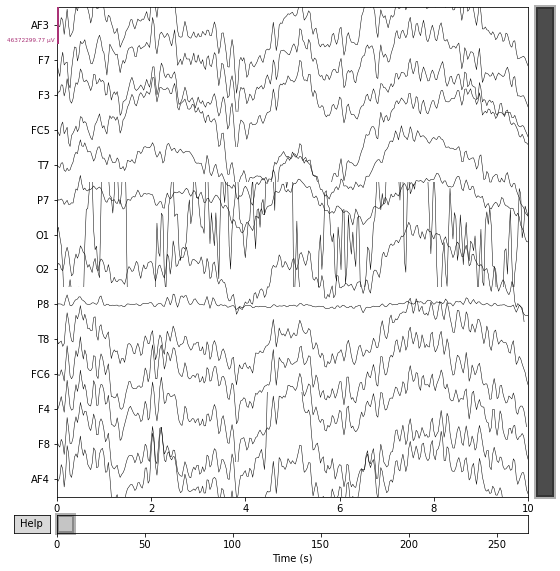

Opening raw-browser...


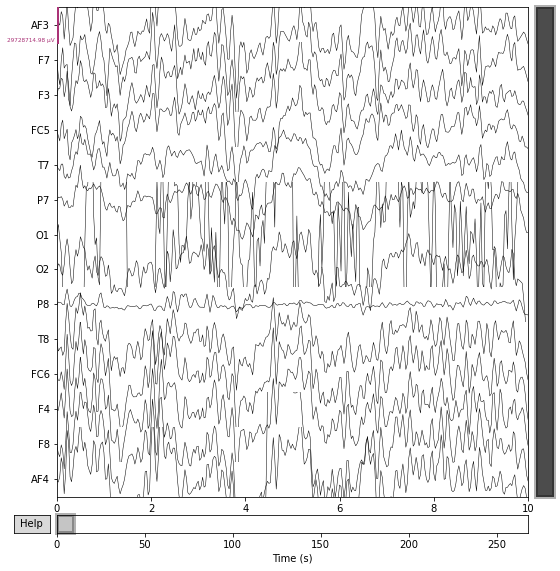

<Figure size 432x288 with 0 Axes>

In [97]:
import matplotlib
# matplotlib.use('Qt5Agg')
# f, axs = plt.subplots(2, 1, figsize=(10, 5))
# _ = f.suptitle('target / non target ', fontsize=20)
# _ = evoked_t.plot(axes=axs[0], show=False, time_unit='s')
# _ = evoked_nt.plot(axes=axs[ 1], show=False, time_unit='s')


raw_filt.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[0], show=False,
             scalings='auto')
raw_filt2.plot(duration=10, proj=False, n_channels=len(raw.ch_names),
         remove_dc=True, #axes=axs[1], show=False,
             scalings='auto')

plt.tight_layout()

Effective window size : 16.000 (s)


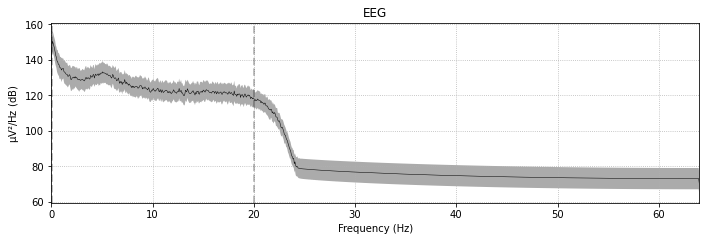

In [23]:
def add_arrows(axes):
    # add some arrows at 60 Hz and its harmonics
    for ax in axes:
        freqs = ax.lines[-1].get_xdata()
        psds = ax.lines[-1].get_ydata()
        for freq in (10, 20, 60):
            idx = np.searchsorted(freqs, freq)
            # get ymax of a small region around the freq. of interest
            y = psds[(idx - 4):(idx + 5)].max()
            ax.arrow(x=freqs[idx], y=y + 18, dx=0, dy=-12, color='red',
                     width=0.1, head_width=3, length_includes_head=True)


fig = raw.plot_psd(fmax=64, average=True)
add_arrows(fig.axes[:2])

Effective window size : 32.000 (s)


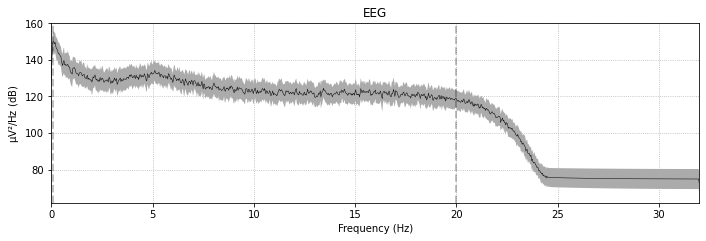

In [28]:
fig = raw_downsampled.plot_psd( average=True)


In [ ]:


current_sfreq = raw.info['sfreq']
desired_sfreq = 90  # Hz
decim = np.round(current_sfreq / desired_sfreq).astype(int)
obtained_sfreq = current_sfreq / decim
lowpass_freq = obtained_sfreq / 3.

raw_filtered = raw.copy().filter(l_freq=None, h_freq=lowpass_freq)
events = mne.find_events(raw_filtered)
epochs = mne.Epochs(raw_filtered, events, decim=decim)

print('desired sampling frequency was {} Hz; decim factor of {} yielded an '
      'actual sampling frequency of {} Hz.'
      .format(desired_sfreq, decim, epochs.info['sfreq']))


In [264]:
picks  = ['FC6']
tmin = -.5
tmax = 1.5
epochs1 = mne.Epochs(raw_filt2, event_arr, 100, tmin, tmax, picks=picks,
                     baseline=None, )
condition1 = epochs1.get_data()  # as 3D matrix

event_id = 2
epochs2 = mne.Epochs(raw_filt2, event_arr, 99, tmin, tmax, picks=picks,
                     baseline=None, )
condition2 = epochs2.get_data()  # as 3D matrix

condition1 = condition1[:, 0, :]  # take only one channel to get a 2D array
condition2 = condition2[:, 0, :]  # take only one channel to get a 2D array

Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 58 events and 257 original time points ...
0 bad epochs dropped
Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 257 original time points ...
0 bad epochs dropped


In [265]:

from mne.stats import permutation_cluster_test
from mne.datasets import sample
threshold = 6.0
T_obs, clusters, cluster_p_values, H0 = \
    permutation_cluster_test([condition1, condition2], n_permutations=1000,
                             threshold=threshold, tail=1, n_jobs=1,
                             out_type='mask')

stat_fun(H1): min=0.000006 max=2.941056
Running initial clustering
Found 0 clusters


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/309217691.py:5: RuntimeWarning: No clusters found, returning empty H0, clusters, and cluster_pv
  permutation_cluster_test([condition1, condition2], n_permutations=1000,


Text(0, 0.5, 'f-values')

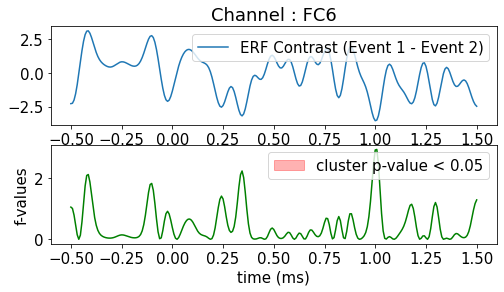

In [266]:
times = epochs1.times
fig, (ax, ax2) = plt.subplots(2, 1, figsize=(8, 4))
channel = picks[0]
ax.set_title('Channel : ' + channel)
ax.plot(times, condition1.mean(axis=0) - condition2.mean(axis=0),
        label="ERF Contrast (Event 1 - Event 2)")
ax.set_ylabel("")
ax.legend()

for i_c, c in enumerate(clusters):
    c = c[0]
    if cluster_p_values[i_c] <= 0.05:
        h = ax2.axvspan(times[c.start], times[c.stop - 1],
                        color='r', alpha=0.3)
    else:
        ax2.axvspan(times[c.start], times[c.stop - 1], color=(0.3, 0.3, 0.3),
                    alpha=0.3)

hf = plt.plot(times, T_obs, 'g')
ax2.legend((h, ), ('cluster p-value < 0.05', ))
ax2.set_xlabel("time (ms)")
ax2.set_ylabel("f-values")

Opening raw-browser...


<Figure size 72x432 with 0 Axes>

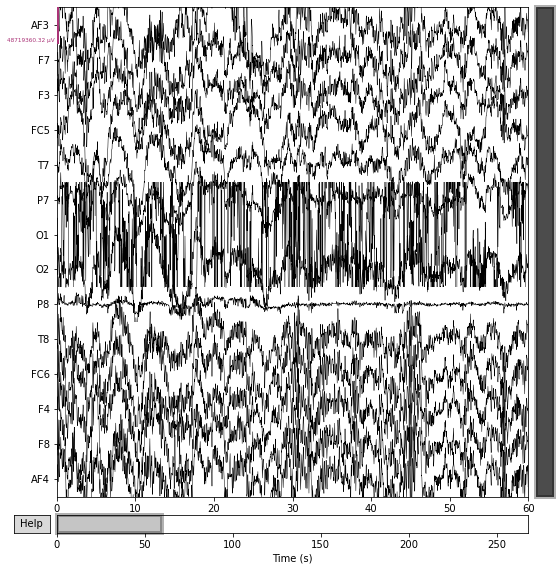

<Figure size 432x288 with 0 Axes>

In [36]:
plt.figure(figsize=(1, 6))
raw_downsampled.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False,
             scalings='auto')
plt.tight_layout()

Opening raw-browser...


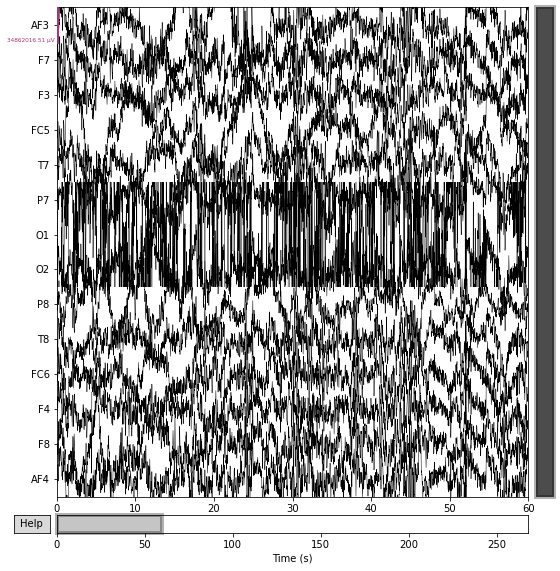

<Figure size 432x288 with 0 Axes>

In [37]:
raw_car.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False,
             scalings='auto')
plt.tight_layout()

In [445]:
259992/1000

259.992

In [148]:
event_id

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11}

In [147]:
 new_event_arr, new_event_id,= utils.modify_events(event_arr=event_arr, event_id=event_id)

In [136]:
from global_configs import globals as GLOB

In [149]:
epochs_highlights_notargets = mne.Epochs(raw_downsampled,
                                         events=event_arr,
                                         event_id={GLOB.HIGHLIGHT_TARGET_FALSE: 99},
                                         tmin=-.2,
                                         tmax=1,
                                         baseline=None,
                                         preload=True)

epochs_highlights_targets = mne.Epochs(raw_downsampled,
                                       events=event_arr,
                                       event_id={GLOB.HIGHLIGHT_TARGET_TRUE: 100},
                                       tmin=-.2,
                                       tmax=1.,
                                       baseline=None,
                                       preload=True)

Not setting metadata
182 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 182 events and 39 original time points ...
92 bad epochs dropped
Not setting metadata
58 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 58 events and 39 original time points ...
28 bad epochs dropped


In [379]:
new_event_arr

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11,
 'highlight_target_true': 100,
 'highlight_target_false': 99}

In [155]:
raw_car.ch_names

['AF3',
 'F7',
 'F3',
 'FC5',
 'T7',
 'P7',
 'O1',
 'O2',
 'P8',
 'T8',
 'FC6',
 'F4',
 'F8',
 'AF4']

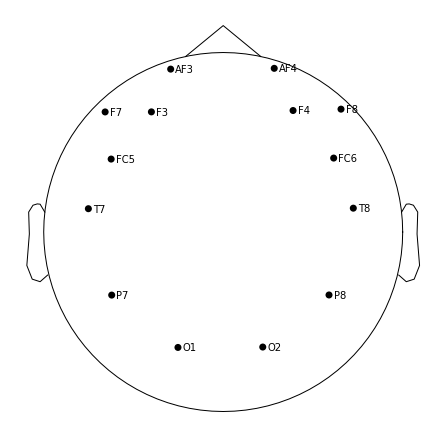

In [43]:

fig= raw_car.plot_sensors(ch_type='eeg', show_names=True,
                             title='Available Channels', show=True )

<Figure size 288x720 with 0 Axes>

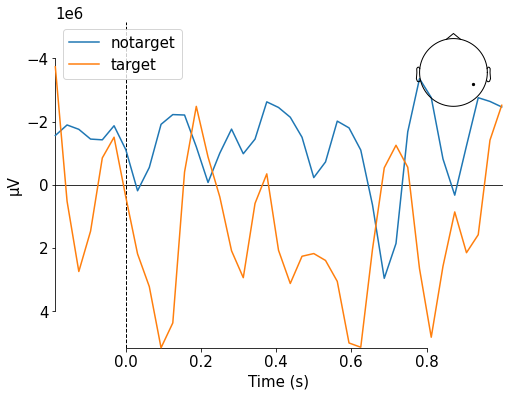

[<Figure size 576x432 with 2 Axes>]

In [226]:
plt.figure(figsize=(4, 10))
ch = 'P8'#'P7'
# average the signals for channel Cz for both conditions:
avg_nt = epochs_highlights_notargets[:60].average(picks=ch)
avg_t = epochs_highlights_targets.average(picks=ch)

# Plot the evoked potentials
evokeds = dict(notarget=avg_nt, target=avg_t)
picks = [f'eeg{n}' for n in range(10, 15)]
mne.viz.plot_compare_evokeds(evokeds, invert_y=1)

In [272]:
epochs_highlights_notargets.to_data_frame()['time'][20:50].values/1000

array([0.156, 0.164, 0.172, 0.18 , 0.188, 0.195, 0.203, 0.211, 0.219,
       0.227, 0.234, 0.242, 0.25 , 0.258, 0.266, 0.273, 0.281, 0.289,
       0.297, 0.305, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352, 0.359,
       0.367, 0.375, 0.383])

In [103]:

# Save the evoked signals
epochs_highlights_notargets.average().save(datadir + '/avg_nt.fif', 
        overwrite=True);
epochs_highlights_targets.average().save(datadir + '/avg_t.fif', 
        overwrite=True);

f=datadir + '/avg_nt.fif'
# fig, axes = plt.subplots(ncols=3, figsize=(8, 8))
evoked_nt =  mne.Evoked(f)
f2=datadir + '/avg_t.fif'
evoked_t = mne.Evoked(f2)

Overwriting existing file.
Overwriting existing file.
    Found the data of interest:
        t =    -203.12 ...    1000.00 ms (highlight_target_false)
        0 CTF compensation matrices available
        nave = 184 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.
    Found the data of interest:
        t =    -203.12 ...    1000.00 ms (highlight_target_true)
        0 CTF compensation matrices available
        nave = 56 - aspect type = 100
No projector specified for this dataset. Please consider the method self.add_proj.


/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/4221130386.py:2: RuntimeWarning: This filename (/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/avg_nt.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  epochs_highlights_notargets.average().save(datadir + '/avg_nt.fif',
/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/4221130386.py:4: RuntimeWarning: This filename (/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/avg_t.fif) does not conform to MNE naming conventions. All evoked files should end with -ave.fif, -ave.fif.gz, _ave.fif or _ave.fif.gz
  epochs_highlights_targets.average().save(datadir + '/avg_t.fif',


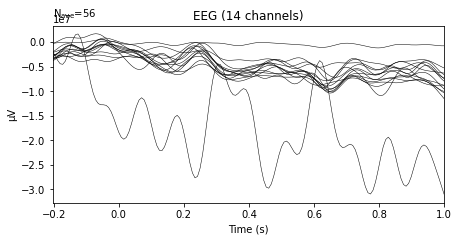

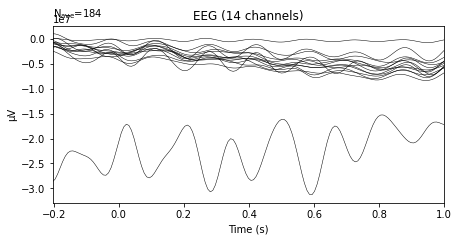

In [104]:


f = evoked_t.plot()
f2 = evoked_nt.plot()

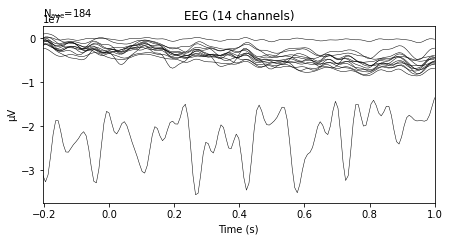

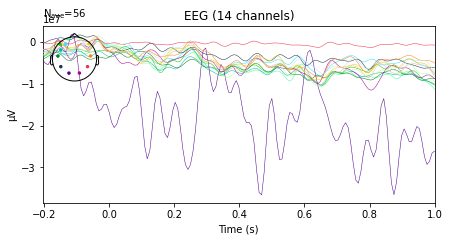

In [62]:
fig1 = evoked_nt.plot()
fig2 = evoked_t.plot(spatial_colors=True)

/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/2229563707.py:8: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  d = evoked_t.plot_topomap(times, ch_type='eeg', time_unit='s', title='target',


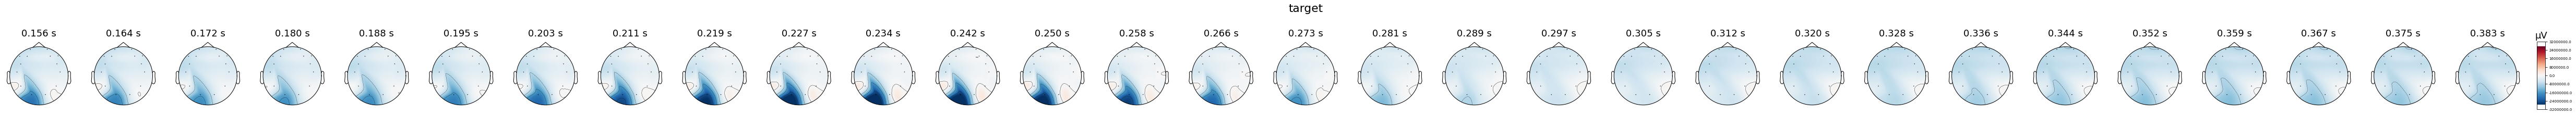

In [225]:
times = [ .281, .305,  .312]
times = [.266, 0.273, 0.281, 0.289,
       0.297, 0.305, 0.312, 0.32 , 0.328, 0.336,]
times = [0.156, 0.164, 0.172, 0.18 , 0.188, 0.195, 0.203, 0.211, 0.219,
       0.227, 0.234, 0.242, 0.25 , 0.258, 0.266, 0.273, 0.281, 0.289,
       0.297, 0.305, 0.312, 0.32 , 0.328, 0.336, 0.344, 0.352, 0.359,
       0.367, 0.375, 0.383]
d = evoked_t.plot_topomap(times, ch_type='eeg', time_unit='s', title='target',
                        # axes=axes[0:]
                         size=1.5,
                        # show_names=True,
                        res=256

                        )

/var/folders/k1/zf0rv7y54_q54zt_vm6nfm040000gn/T/ipykernel_50233/3737603719.py:1: RuntimeWarning: More than 25 topomaps plots requested. This might take a while.
  d2 = evoked_nt.plot_topomap(times, ch_type='eeg', time_unit='s',  title='No target ',


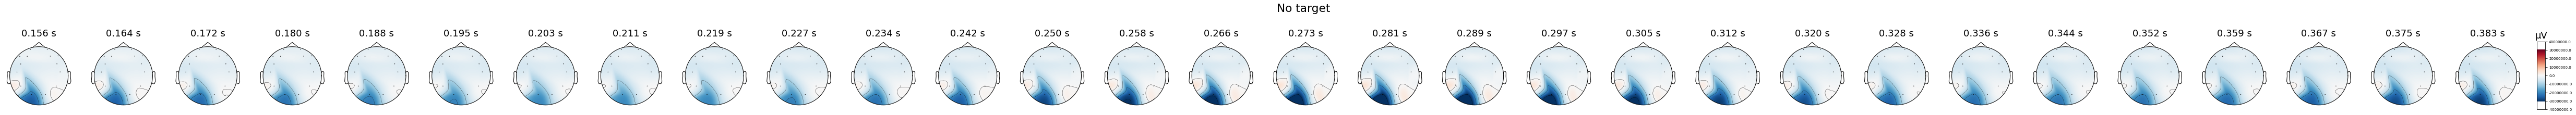

In [227]:

d2 = evoked_nt.plot_topomap(times, ch_type='eeg', time_unit='s',  title='No target ',
                        #  axes=axes[:]
                         size=1.5
)

Not setting metadata
288 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


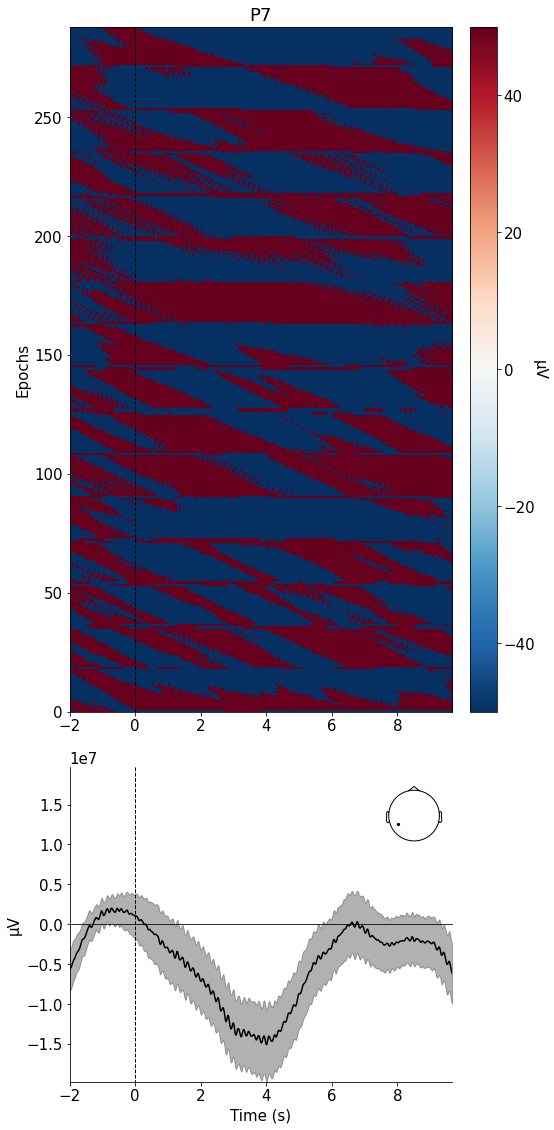

[<Figure size 576x1152 with 4 Axes>]

In [233]:

from mne.viz import plot_epochs_image
# Plot image epoch before xdawn
plot_epochs_image(epochs_, picks=['P7'], vmin=-50, vmax=50)

In [234]:
! pip install pyprep

# detect bad channels automaticlly 

In [237]:

from scipy import signal as signal
from time import perf_counter

from pyprep.find_noisy_channels import NoisyChannels

###############################################################################
# Assign the mne object to the :class:`NoisyChannels` class. The resulting object
# will be the place where all following methods are performed.

nd = NoisyChannels(raw, random_state=1337)
nd2 = NoisyChannels(raw, random_state=1337)

###############################################################################
# Find all bad channels using channel-wise RANSAC and print a summary
start_time = perf_counter()
nd.find_bad_by_ransac(channel_wise=True)
print("--- %s seconds ---" % (perf_counter() - start_time))

# Repeat channel-wise RANSAC using a single channel at a time. This is slower
# but needs less memory.
start_time = perf_counter()
nd2.find_bad_by_ransac(channel_wise=True, max_chunk_size=1)
print("--- %s seconds ---" % (perf_counter() - start_time))

###############################################################################
# Now the bad channels are saved in `bads` and we can continue processing our
# `raw` object. For more information, we can access attributes of the ``nd``
# instance:

# Check channels that go bad together by correlation (RANSAC)
print(nd.bad_by_ransac)
# assert set(bad_ch_names) == set(nd.bad_by_ransac)

# Check that the channel wise RANSAC yields identical results
print(nd2.bad_by_ransac)
# assert set(bad_ch_names) == set(nd2.bad_by_ransac)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 423 samples (3.305 sec)

Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 14
Total # of chunks: 1
Current chunk: 1 
RANSAC done!
--- 0.6747480269987136 seconds ---
Executing 

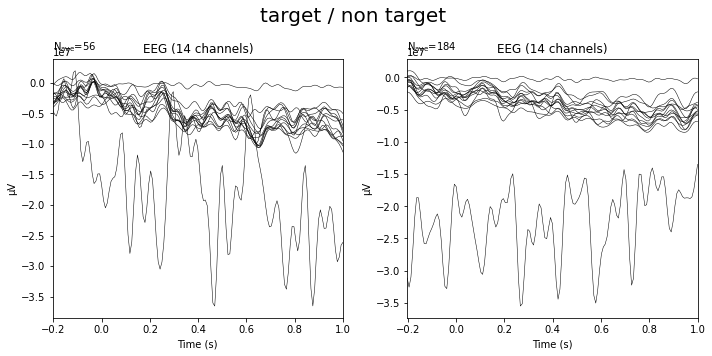

In [73]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
_ = f.suptitle('target / non target ', fontsize=20)
_ = evoked_t.plot(axes=axs[0], show=False, time_unit='s')
_ = evoked_nt.plot(axes=axs[ 1], show=False, time_unit='s')
plt.tight_layout()

Opening raw-browser...


<Figure size 360x216 with 0 Axes>

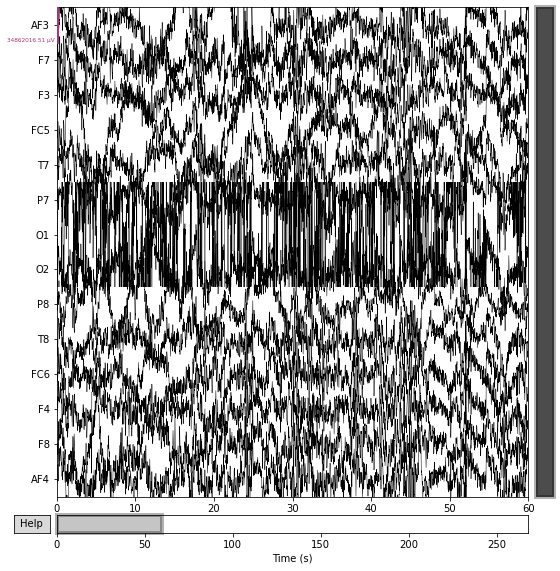

In [54]:
plt.figure(figsize=(5, 3))
fig = raw_car.plot(duration=60, proj=False, n_channels=len(raw.ch_names),
         remove_dc=False, scalings='auto',
          )

Opening epochs-browser...
Opening epochs-browser...


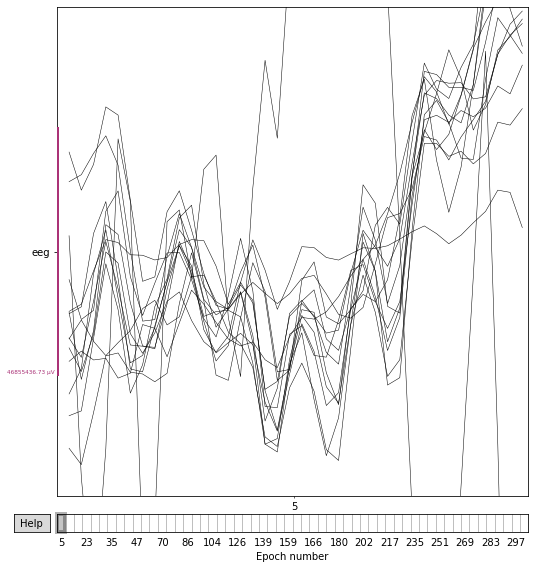

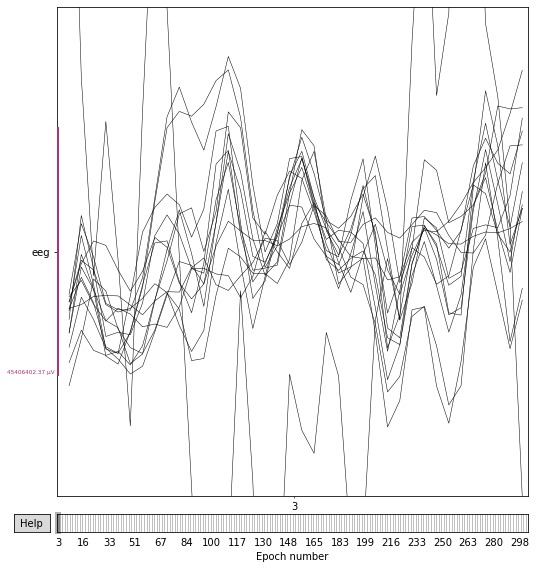

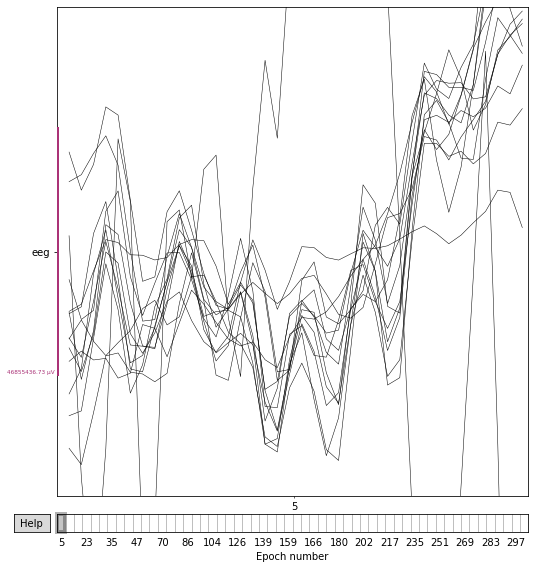

In [119]:
epochs_highlights_notargets.plot(scalings='auto', n_epochs=1, show=False, 
                                 butterfly=True)
epochs_highlights_targets.plot(scalings='auto', n_epochs=1, show=False, 
                                 butterfly=True)

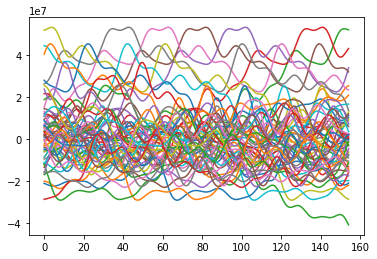

In [116]:
import matplotlib.pyplot as plt
plt.figure()
df_epochs_t = epochs_highlights_targets.to_data_frame()
df_epochs_nt = epochs_highlights_notargets.to_data_frame()
epochs_plot = df_epochs_nt['epoch'].unique()[:58]
for ep in epochs_plot:
    v = df_epochs_nt.loc[(df_epochs_nt['epoch'].isin([ep]))][ch].values
    plt.plot(v)

In [146]:
tmin, tmax = -exp_durations['baseline_length'], total_trial_duration
epochs = mne.Epochs(raw_car,
                              events=event_arr,
                              event_id=event_id,
                              tmin=tmin,
                              tmax=tmax,
                              baseline=(-exp_durations['baseline_length'], 0),
                              # We apply baseline correction here !!!!!!!!!!!!!
                              preload=True,
                              event_repeated='drop')


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
288 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 288 events and 1495 original time points ...
1 bad epochs dropped


In [147]:
epochs_resampled = epochs.resample(64)

TypeError: resample() got an unexpected keyword argument 'copy'

In [107]:
file = '/Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/raw/*_eeg.xdf'

epochs_list = []
for trial_no, trial in enumerate(sorted(glob.glob(file))):
    print("TRIAL NO ", trial)
    raw, event_arr, event_id = load_xdf_data(file=trial)
    print('data loaded')

    # Implement the band-pass filter
    flow, fhigh = 0.1, 20
    raw_filt = raw.filter(flow, fhigh)

    # Apply Common Average Referencing.
    raw_car, _ = mne.set_eeg_reference(raw_filt, 'average', copy=True, ch_type='eeg')

    # Now we want to epoch our data to trials and do a baseline correction.
    total_trial_duration = exp_durations['baseline_length'] + exp_durations['target_length'] + \
                           exp_durations['highlight_length'] * exp_durations['num_highlights'] + \
                           exp_durations['inter_highlight_length'] * (exp_durations['num_highlights'] - 1)
#     tmin, tmax = -exp_durations['baseline_length'], total_trial_duration
#     epochs_list.append(mne.Epochs(raw_car,
#                                   events=event_arr,
#                                   event_id=event_id,
#                                   tmin=tmin,
#                                   tmax=tmax,
#                                   baseline=(-exp_durations['baseline_length'], 0),
#                                   # We apply baseline correction here !!!!!!!!!!!!!
#                                   preload=True,
#                                   event_repeated='drop'))
# Concatenate the epochs
# epochs = mne.concatenate_epochs(epochs_list)

# Get a subselection of epochs that resembles the trials
sub_epochs_trials = epochs['trial_begin']

# Now we epoch the trials to get highlights
tmin, tmax = 0, .65 #exp_durations['highlight_length']
epochs_highlights = mne.Epochs(raw_car,
                               events=event_arr,
                               event_id=event_id,
                               tmin=tmin,
                               tmax=tmax,
                               baseline=None,  # we don't apply baseline correction here !!!!!!!!!!!!!
                               preload=True,
                               event_repeated='drop')

# Get the two classes of epochs that involves the P300 response and not
sub_epochs = epochs_highlights['highlight_down', 'highlight_up']

# After this we should exclude bad epochs. Click on the epochs in the window to drop them. Close the window to save.
sub_epochs.plot(scalings='auto', butterfly=True)

# We can also check epochs with the PSD.
sub_epochs.plot_psd()

# # %%
# with open(r'C:\Users\AYCA\PycharmProjects\biosignal_stars\data\sub_epochs_trial.pkl', 'wb') as file:
#     # Save the sub-epochs for signal processing
#     pickle.dump(sub_epochs, file)

TRIAL NO  /Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/raw/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-001_eeg.xdf
openvibesignal --> data stream
p300_markers --> marker stream
Creating RawArray with float64 data, n_channels=14, n_times=38912
    Range : 0 ... 38911 =      0.000 ...   303.992 secs
Ready.
data loaded
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 4225 samples (33.008 sec)

Applying average reference.
Applying a custom ('EEG',) reference.


Stream 1: Calculated effective sampling rate 0.0000 Hz is different from specified rate 128.0000 Hz.


TRIAL NO  /Users/mariyana.cholakova/Documents/mnse/sem4/bspm/git_repo/biosignal_stars/data/raw/sub-Majd_ses-15-07-2022-short-bg_task-Default_run-002_eeg.xdf
openvibesignal --> data stream
p300_markers --> marker stream


IndexError: index 0 is out of bounds for axis 0 with size 0

## Visualize and explore 

In [156]:
evplot = ['baseline_for_trial', 'block_end', 
#  'highlight_down', 'highlight_left', 'highlight_right', 'highlight_up',
 'pause', 'target_down', 'target_left', 'target_right', 'target_up', 'trial_begin',
 'highlight_target_true', 'highlight_target_false']

In [158]:
event_id

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11,
 'highlight_target_true': 100,
 'highlight_target_false': 99}

In [159]:
event_id2 = {'baseline_for_trial': 0,
 'block_end': 1,
#  'highlight_down': 2,
#  'highlight_left': 3,
#  'highlight_right': 4,
#  'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11,
 'highlight_target_true': 100,
 'highlight_target_false': 99}

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
289 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 289 events and 1495 original time points ...
1 bad epochs dropped
You seem to have overlapping epochs. Some event lines may be duplicated in the plot.
Opening epochs-browser...


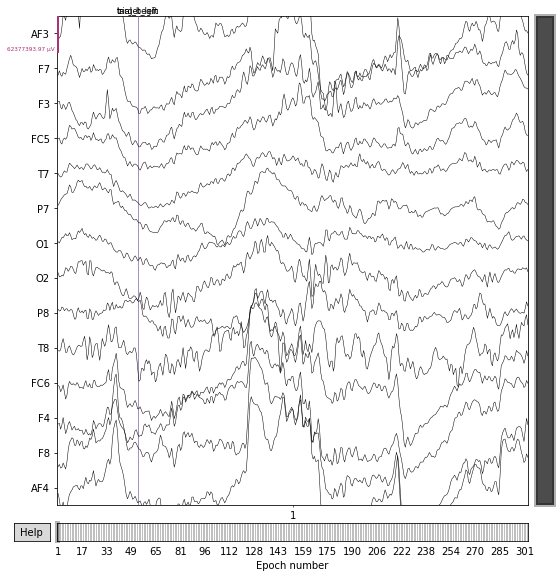

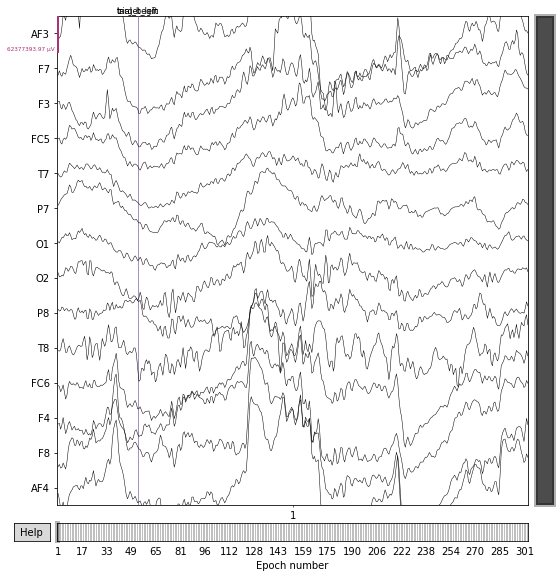

In [174]:
tmin, tmax = -exp_durations['baseline_length'], total_trial_duration
epochs_ = mne.Epochs(raw_filt,
                              events=event_arr,
                              event_id=event_id2,
                              tmin=tmin,
                              tmax=tmax,
                              baseline=(-exp_durations['baseline_length'], 0),
                              # We apply baseline correction here !!!!!!!!!!!!!
                              preload=True,
                              event_repeated='drop'
                    )

trials = mne.pick_events(event_arr, include=[event_id[x] for x in evplot])
epochs_.plot(events=trials, event_id=event_id2, n_epochs=1, scalings='auto'
# #                     event_color=dict(button='red', face='blue')
           )
# epochs_.plot(n_epochs=1, scalings='auto', event_id=event_id2)

In [186]:
event_id3 = {'base': 0,
 'b_end': 1,
 'pause': 6,
 'targ': 7,
 'targ2': 8,
 'targ3': 9,
 'targ4': 10,
 'triaL': 11,
 't': 100,
 'nt': 99}

Setting up band-pass filter from 1 - 10 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 10.00 Hz: -6.02, -6.02 dB

Opening raw-browser...


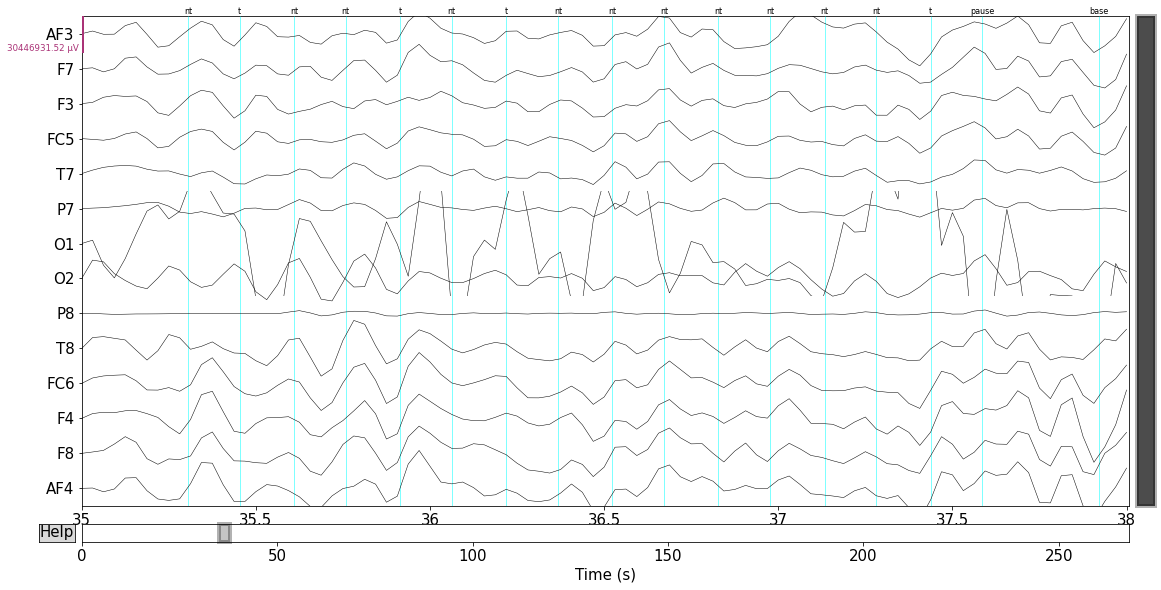

In [224]:
import matplotlib as mpl
from pylab import cm
import seaborn as sns
import matplotlib
mpl.rcParams['figure.figsize'] = (8, 16)
plt.rcParams['font.size'] = 15
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')  

# fig, axes = plt.subplots(figsize=(7.5, 8.5), nrows=2, ncols=1)
fig = raw_filt2.plot(start=35, duration=3, scalings='auto', events = event_arr ,
#                     event_color={'t':'r'},
                    event_id=event_id3, remove_dc=1 , lowpass=10, highpass=1 )

Opening raw-browser...


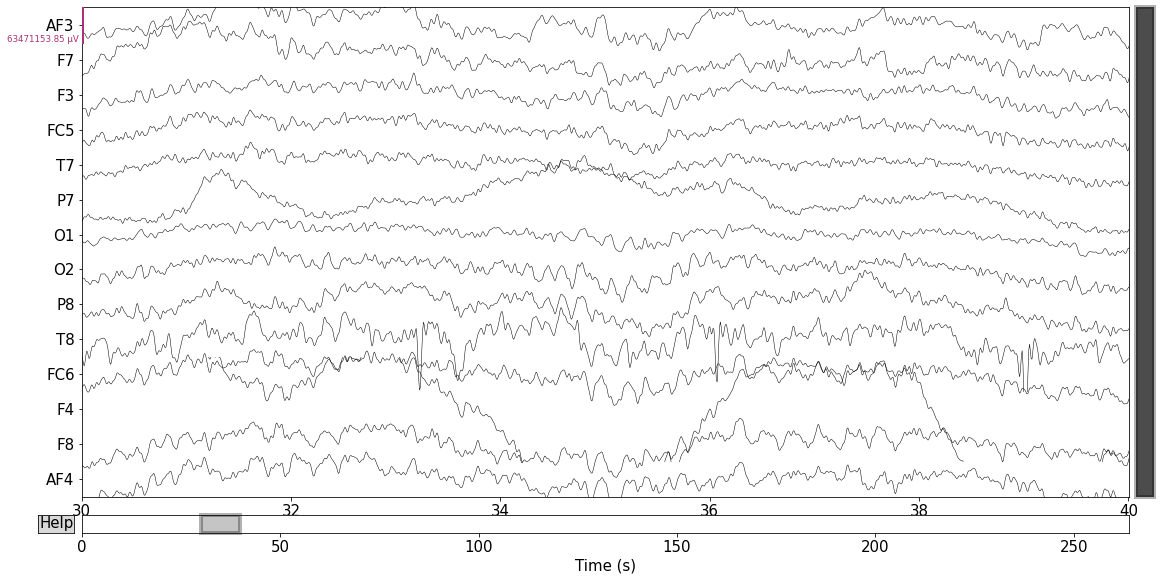

Text(0.5, 0.98, 'No reference')

In [215]:
# for avg referencing ? projector applied:
proj = False
with mne.viz.use_browser_backend('matplotlib'):
    fig = raw.plot(n_channels=14, proj=proj, scalings='auto', #dict(eeg=50e-6)
               start = 30,
                  )
fig.subplots_adjust(top=0.9)  # make room for title
ref = 'Average' if proj else 'No'
fig.suptitle(f'{ref} reference', size='xx-large', weight='bold')


Opening raw-browser...


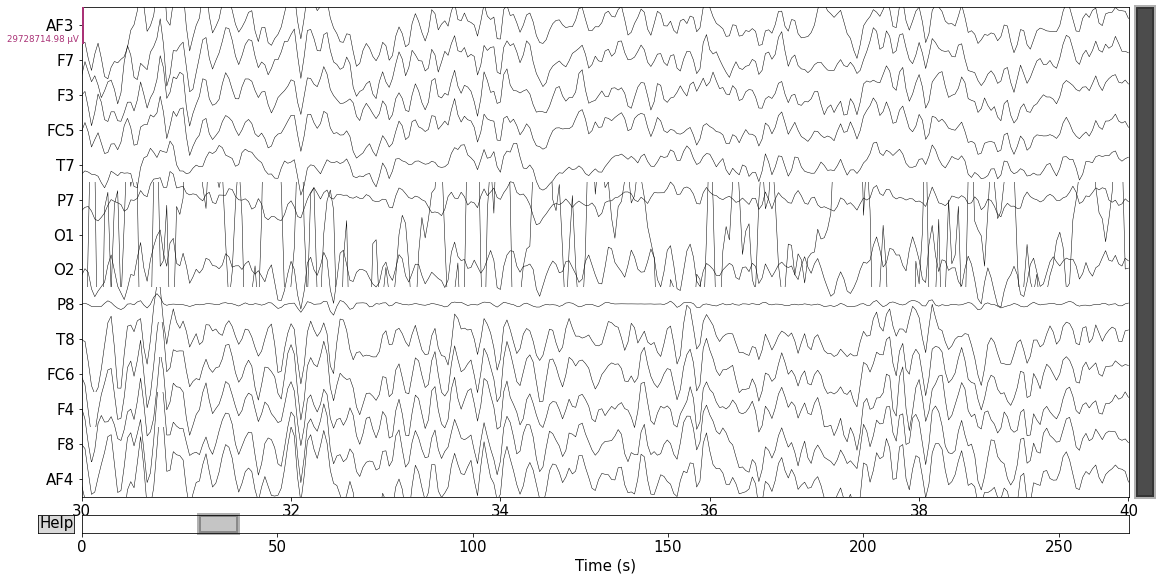

Text(0.5, 0.98, 'Average reference')

In [217]:

proj = True
with mne.viz.use_browser_backend('matplotlib'):
    fig = raw_filt2.plot(n_channels=14, proj=proj, scalings='auto'#dict(eeg=50e-6)
                   , start=30
                  )
fig.subplots_adjust(top=0.9)  # make room for title
ref = 'Average' if proj else 'No'
fig.suptitle(f'{ref} reference', size='xx-large', weight='bold')

In [ ]:
how to downsample properly 

In [539]:
plt.figure(figsize=(10, 8))
epochs_highlights_notargets.plot(scalings='auto', butterfly=False, )
# 

TypeError: plot() got an unexpected keyword argument 'duration'

<Figure size 1440x1152 with 0 Axes>

## removing bad channels

# Raw load

In [143]:
streams, header = pyxdf.load_xdf(file)

In [396]:
header


{'info': defaultdict(list,
             {'version': ['1.0'], 'datetime': ['2022-07-15T17:09:54+0200']})}

In [144]:
streams

[{'info': defaultdict(list,
              {'name': ['openvibeSignal'],
               'type': ['signal'],
               'channel_count': ['14'],
               'nominal_srate': ['128'],
               'channel_format': ['float32'],
               'source_id': ['(0x9c95424b, 0x02a1a421)'],
               'version': ['1'],
               'created_at': ['140.76876350000001'],
               'uid': ['042fe1ac-c778-4acf-a899-44bf83a498d8'],
               'session_id': ['default'],
               'hostname': ['DESKTOP-R9E0FT8'],
               'v4address': [None],
               'v4data_port': ['16572'],
               'v4service_port': ['16572'],
               'v6address': [None],
               'v6data_port': ['16572'],
               'v6service_port': ['16572'],
               'desc': [defaultdict(list,
                            {'channels': [defaultdict(list,
                                          {'channel': [defaultdict(list,
                                                    

In [ ]:
797.0311938, 741.6177939000000']

'140.76876350000001', '1288'

In [510]:
1815865 - 1814373

1492

In [411]:
1327 - 140

1187

In [345]:
1617.6240177 - 1617.7768087, 1608.6760559 - 1608.8280037

(-0.15279099999997925, -0.1519478000000163)

In [334]:
1618.0873133 - 1496.7345265

121.3527868000001

In [342]:
16* (total_trial_duration + 0.075) +1.4 + 3

160.4

In [316]:
exp_durations

{'highlight_length': 0.1,
 'target_length': 2.5,
 'baseline_length': 2,
 'delay_baseline_arrows': 0.1,
 'inter_highlight_length': 0.075,
 'inter_block_length': 3,
 'inter_trial_length': 0.1,
 'num_highlights': 30,
 'target_color': [0, 0, 255],
 'highlight_color': [0, 255, 0]}

In [317]:
event_id

{'baseline_for_trial': 0,
 'block_end': 1,
 'highlight_down': 2,
 'highlight_left': 3,
 'highlight_right': 4,
 'highlight_up': 5,
 'pause': 6,
 'target_down': 7,
 'target_left': 8,
 'target_right': 9,
 'target_up': 10,
 'trial_begin': 11}

In [398]:
for ev, t in event_id.items():
    print(f"{ev} : ")
    print((event_arr[:, 2]==t).sum())
    print('-----')

baseline_for_trial : 
16
-----
block_end : 
2
-----
highlight_down : 
0
-----
highlight_left : 
0
-----
highlight_right : 
0
-----
highlight_up : 
0
-----
pause : 
14
-----
target_down : 
4
-----
target_left : 
4
-----
target_right : 
4
-----
target_up : 
4
-----
trial_begin : 
16
-----
highlight_target_true : 
58
-----
highlight_target_false : 
182
-----


In [419]:
((streams[0]['time_stamps'].max() -streams[0]['time_stamps'].min())), ((streams[1]['time_stamps'].max() -streams[1]['time_stamps'].min()))


(259.98492645852093, 121.38039589564141)

In [412]:
((streams[0]['time_stamps'].max(),streams[0]['time_stamps'].min())), ((streams[1]['time_stamps'].max(),streams[1]['time_stamps'].min()))


((77514.41284156442, 77254.4279151059), (76352.59542322878, 76231.21502733314))

In [418]:
from pylsl import local_clock
local_clock()

6.0281745830189

In [407]:
streams[0]['time_stamps'].shape, streams[1]['time_stamps'].shape

((33280,), (304,))

In [422]:
3328/128,

(26.0,)

In [421]:
streams[0]['time_stamps'].min()- streams[1]['time_stamps'].min(), streams[0]['time_stamps'].max()- streams[1]['time_stamps'].max()

(1023.2128877727664, 1161.817418335646)

In [488]:
streams[0]['time_series'].shape

(33280, 14)

<Figure size 1728x216 with 0 Axes>

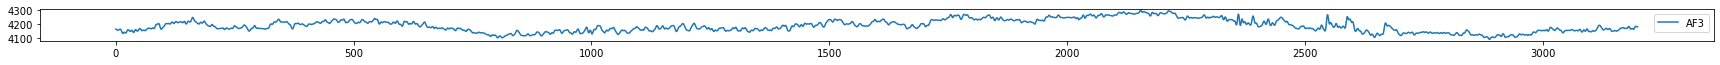

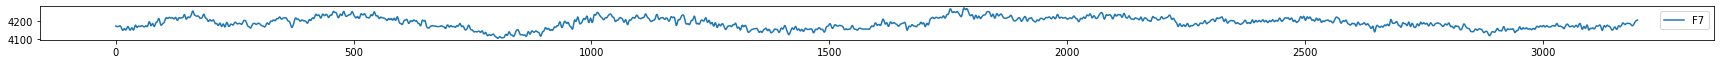

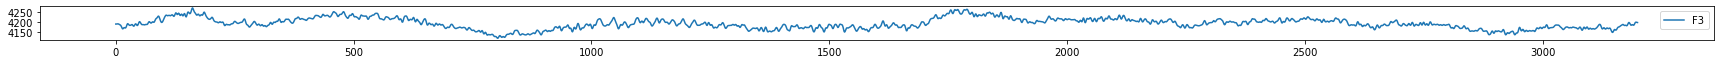

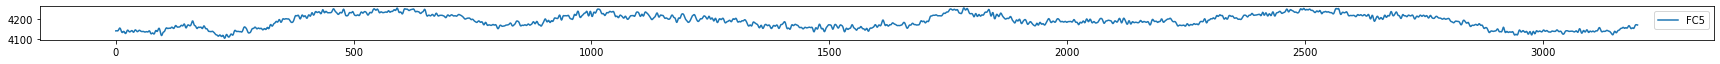

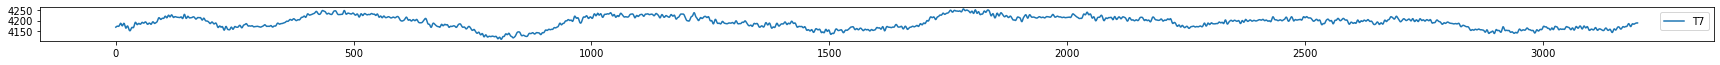

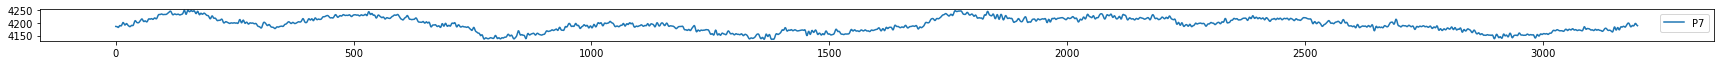

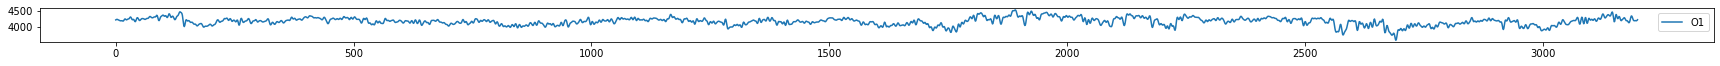

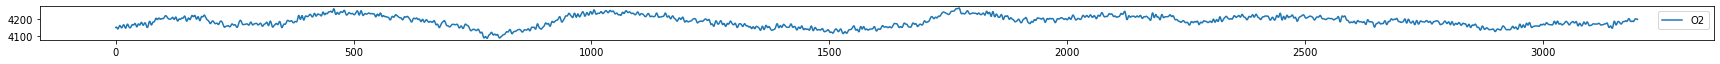

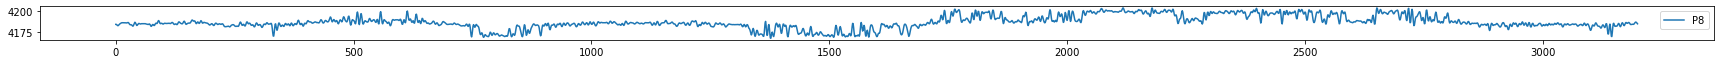

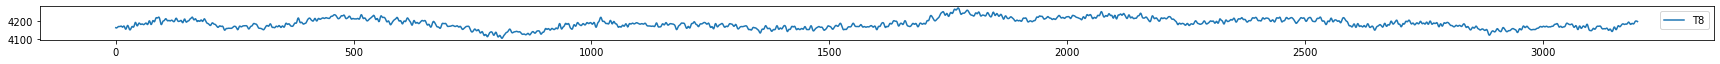

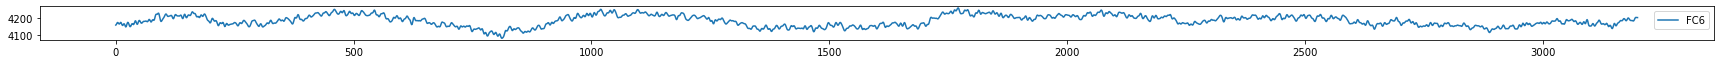

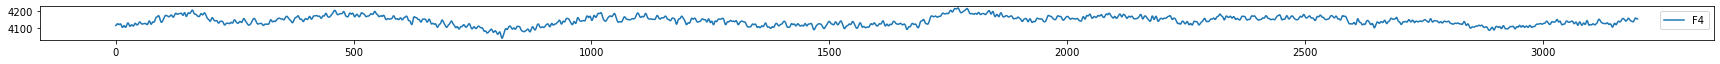

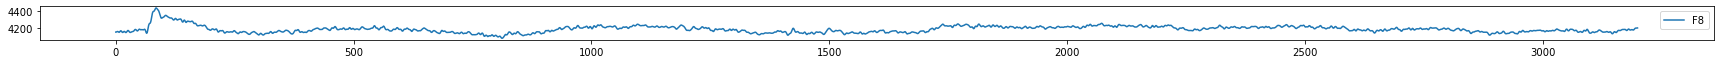

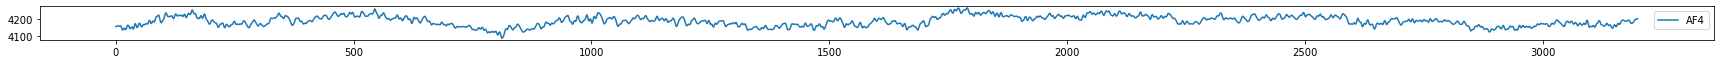

In [106]:
plt.figure(figsize=(24, 3))
for i in range(0,14):
    plt.figure(figsize=(24, 1))
    plt.plot(streams[0]['time_series'][500:3700, i], label = raw.ch_names[i])
    plt.tight_layout()
    plt.legend()

In [403]:
1477.454033000000 - 140.76876350000001,1458 - 1336.


(1336.6852695, 122.0)

In [70]:

# Read the XDF file
streams2, header = pyxdf.load_xdf(file, 'HandleClockSynchronization',)

ValueError: Argument 'select_streams' must be an int, a list of ints or a list of dicts.